For entailment, we need to use [DataPairCorpus](https://github.com/flairNLP/flair/blob/v0.11/flair/datasets/text_text.py#L198=) and [TextPairClassifier](https://github.com/flairNLP/flair/blob/v0.11/flair/models/pairwise_classification_model.py#L10=).

Example of NLI here: https://github.com/flairNLP/flair/issues/2536

## Global Variables

In [1]:
BATCH_SIZE = 8
LEARNING_RATE = 1e-3
EPOCHS = 20
BINARY_CLASS = False
EMBEDDING = 'flair' # glove | elmo | flair

## Set Main Paths

In [2]:
import os

try:
    from google.colab import drive
    drive.mount('/content/drive')
except:
    pass

if os.path.isdir('/content/drive'): # Google Drive
    save_dir = '/content/drive/MyDrive/models'
    corpus_folder = '/content/drive/MyDrive/data/cpca/'
    platform = 'colab'
elif os.path.isdir('/kaggle/working'): # Kaggle
    save_dir = '/kaggle/working'
    corpus_folder = '../input/riposte/cpca/'
    platform = 'kaggle'
else: # Others
    save_dir = './'
    corpus_folder = './data/cpca/'
    platform = 'other'

corpus_folder = f'{corpus_folder}/sampled'
print(f'Platform: {platform}')

Platform: kaggle


## Install Requirements

There are problems to use ELMo with latest versions of Flair. Related open issues:

* https://github.com/flairNLP/flair/issues/1729
* https://github.com/flairNLP/flair/issues/2647#issuecomment-1050891147=

For the rest, we prefer to use the latest version.

In [3]:
if EMBEDDING == 'elmo':
    !pip install allennlp==0.9.0
!pip install flair

     |████████████████████████████████| 401 kB 261 kB/s            
     |████████████████████████████████| 788 kB 4.3 MB/s            
  Preparing metadata (setup.py) ... - done
  Installing build dependencies ... - \ | / - \ done
  Getting requirements to build wheel ... - \ | / - done
  Preparing metadata (pyproject.toml) ... - \ | / - done
     |████████████████████████████████| 53 kB 1.3 MB/s             
  Preparing metadata (setup.py) ... - done
     |████████████████████████████████| 1.2 MB 11.5 MB/s            
     |████████████████████████████████| 981 kB 28.6 MB/s            
  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
  Created wheel for gdown: filename=gdown-4.4.0-py3-none-any.whl size=14759 sha256=024e0d923c1246cc7da053f34af9bed3aa026afc8e546e540ab1ed1f0423870f
  Stored in directory: /root/.cache/pip/wheels/fb/c3/0e/c4d8ff8bfcb0461afff199471449f6

# Flair Extension

Flair does not support multi-label corpus in data-pair datasets. So we will create specific dataset and corpus classes. The code is based on [DataPairDataset](https://github.com/flairNLP/flair/blob/v0.11/flair/datasets/text_text.py#L312-L444=) class to support multi-label, and scores.

In [4]:
from flair.datasets  import DataPairDataset
from flair.data import Sentence, TextPair
from pathlib import Path
from typing import List, Union

class DataPairMultilabelDataset(DataPairDataset):
    def __init__(
        self,
        path_to_data: Union[str, Path],
        columns: List[int] = [0, 1, 2],
        max_tokens_per_doc=-1,
        max_chars_per_doc=-1,
        use_tokenizer=True,
        in_memory: bool = True,
        label_type: str = None,
        skip_first_line: bool = False,
        separator: str = "\t",
        encoding: str = "utf-8",
        label: bool = True,
    ):
        """
        Creates a Dataset for pairs of sentences/paragraphs. The file needs to be in a column format,
        where each line has a column for the first sentence/paragraph, the second sentence/paragraph and the label
        seperated by e.g. '\t' (just like in the glue RTE-dataset https://gluebenchmark.com/tasks) .
        For each data pair we create a flair.data.DataPair object.
        :param path_to_data: path to the data file
        :param columns: list of integers that indicate the respective columns. The first entry is the column
        for the first sentence, the second for the second sentence and the third for the label. Default [0,1,2]
        :param max_tokens_per_doc: If set, shortens sentences to this maximum number of tokens
        :param max_chars_per_doc: If set, shortens sentences to this maximum number of characters
        :param use_tokenizer: Whether or not to use in-built tokenizer
        :param in_memory: If True, data will be saved in list of flair.data.DataPair objects, other wise we use lists with simple strings which needs less space
        :param label_type: Name of the label of the data pairs
        :param skip_first_line: If True, first line of data file will be ignored
        :param separator: Separator between columns in the data file
        :param encoding: Encoding of the data file
        :param label: If False, the dataset expects unlabeled data
        """

        path_to_data = Path(path_to_data)

        # stop if file does not exist
        assert path_to_data.exists()

        self.in_memory = in_memory

        self.use_tokenizer = use_tokenizer

        self.max_tokens_per_doc = max_tokens_per_doc

        self.label = label

        assert label_type is not None
        self.label_type = label_type

        self.total_data_count: int = 0

        if self.in_memory:
            self.data_pairs: List[DataPair] = []
        else:
            self.first_elements: List[str] = []
            self.second_elements: List[str] = []
            self.labels: List[Optional[str], float] = []

        with open(str(path_to_data), encoding=encoding) as source_file:

            source_line = source_file.readline()

            if skip_first_line:
                header_line = source_line.strip().split(separator)
                source_line = source_file.readline()

            while source_line:

                source_line_list = source_line.strip().split(separator)

                first_element = source_line_list[columns[0]]
                second_element = source_line_list[columns[1]]

                if self.label:
                    pair_labels = []
                    for column in columns[2:]:
                        score = float(source_line_list[column])
                        if score > 0:
                            label: Optional[str] = header_line[column]
                            pair_labels.append([label, score])
                else:
                    pair_labels = None

                if max_chars_per_doc > 0:
                    first_element = first_element[:max_chars_per_doc]
                    second_element = second_element[:max_chars_per_doc]

                if self.in_memory:
                    data_pair = self._make_data_pair(first_element, second_element, pair_labels)
                    self.data_pairs.append(data_pair)
                else:
                    self.first_elements.append(first_element)
                    self.second_elements.append(second_element)
                    if self.label:
                        self.labels.append(pair_labels)

                self.total_data_count += 1

                source_line = source_file.readline()

    # create a DataPair object from strings
    def _make_data_pair(self, first_element: str, second_element: str, labels: str = None):

        first_sentence = Sentence(first_element, use_tokenizer=self.use_tokenizer)
        second_sentence = Sentence(second_element, use_tokenizer=self.use_tokenizer)

        if self.max_tokens_per_doc > 0:
            first_sentence.tokens = first_sentence.tokens[: self.max_tokens_per_doc]
            second_sentence.tokens = second_sentence.tokens[: self.max_tokens_per_doc]

        data_pair = TextPair(first_sentence, second_sentence)

        if labels:
            for label, score in labels:
                data_pair.add_label(typename=self.label_type, value=label, score=score)

        return data_pair

In [5]:
from flair.data import Corpus
from flair.datasets.base import find_train_dev_test_files

class DataPairMultilabelCorpus(Corpus):
    def __init__(
        self,
        data_folder: Union[str, Path],
        columns: List[int] = [0, 1, 2],
        train_file=None,
        test_file=None,
        dev_file=None,
        use_tokenizer: bool = True,
        max_tokens_per_doc=-1,
        max_chars_per_doc=-1,
        in_memory: bool = True,
        label_type: str = None,
        autofind_splits=True,
        sample_missing_splits: bool = True,
        skip_first_line: bool = False,
        separator: str = "\t",
        encoding: str = "utf-8",
    ):
        """
        Corpus for tasks involving pairs of sentences or paragraphs. The data files are expected to be in column format where each line has a colmun
        for the first sentence/paragraph, the second sentence/paragraph and the labels, respectively. The columns must be separated by a given separator (default: '\t').
        :param data_folder: base folder with the task data
        :param columns: List that indicates the columns for the first sentence (first entry in the list), the second sentence (second entry) and label (last entry).
                        default = [0,1,2]
        :param train_file: the name of the train file
        :param test_file: the name of the test file, if None, dev data is sampled from train (if sample_missing_splits is true)
        :param dev_file: the name of the dev file, if None, dev data is sampled from train (if sample_missing_splits is true)
        :param use_tokenizer: Whether or not to use in-built tokenizer
        :param max_tokens_per_doc: If set, shortens sentences to this maximum number of tokens
        :param max_chars_per_doc: If set, shortens sentences to this maximum number of characters
        :param in_memory: If True, data will be saved in list of flair.data.DataPair objects, other wise we use lists with simple strings which needs less space
        :param label_type: Name of the label of the data pairs
        :param autofind_splits: If True, train/test/dev files will be automatically identified in the given data_folder
        :param sample_missing_splits: If True, a missing train/test/dev file will be sampled from the available data
        :param skip_first_line: If True, first line of data files will be ignored
        :param separator: Separator between columns in data files
        :param encoding: Encoding of data files
        :return: a Corpus with annotated train, dev and test data
        """

        # find train, dev and test files if not specified
        dev_file, test_file, train_file = find_train_dev_test_files(
            data_folder,
            dev_file,
            test_file,
            train_file,
            autofind_splits=autofind_splits,
        )

        # create DataPairDataset for train, test and dev file, if they are given

        train = (
            DataPairMultilabelDataset(
                train_file,
                columns=columns,
                use_tokenizer=use_tokenizer,
                max_tokens_per_doc=max_tokens_per_doc,
                max_chars_per_doc=max_chars_per_doc,
                in_memory=in_memory,
                label_type=label_type,
                skip_first_line=skip_first_line,
                separator=separator,
                encoding=encoding,
            )
            if train_file is not None
            else None
        )

        test = (
            DataPairMultilabelDataset(
                test_file,
                columns=columns,
                use_tokenizer=use_tokenizer,
                max_tokens_per_doc=max_tokens_per_doc,
                max_chars_per_doc=max_chars_per_doc,
                in_memory=in_memory,
                label_type=label_type,
                skip_first_line=skip_first_line,
                separator=separator,
                encoding=encoding,
            )
            if test_file is not None
            else None
        )

        dev = (
            DataPairMultilabelDataset(
                dev_file,
                columns=columns,
                use_tokenizer=use_tokenizer,
                max_tokens_per_doc=max_tokens_per_doc,
                max_chars_per_doc=max_chars_per_doc,
                in_memory=in_memory,
                label_type=label_type,
                skip_first_line=skip_first_line,
                separator=separator,
                encoding=encoding,
            )
            if dev_file is not None
            else None
        )

        super(DataPairMultilabelCorpus, self).__init__(
            train,
            dev,
            test,
            sample_missing_splits=sample_missing_splits,
            name=str(data_folder),
        )

## Load the Corpus

In [6]:
!head -5 ../input/riposte/cpca/topic/train_multi.csv

topic	claim	premise	<begging>	<hasty>	<none>	<questionable_cause>	<red_herring>	types
To Tip or Not to Tip	Not to tip	Raise prices to actually provide something like a living wage to servers so they don't have to rely on unreliable tips.	1	1	0	0	1	<red_herring>,<hasty>,<begging>
Is the Bar Too Low to Get Into Law School?	The bar is not too low to get into law school	I attended a night school and if the ABA raised the bar I wouldn't have a California license.	1	1	0	1	1	<red_herring>,<questionable_cause>,<hasty>,<begging>
Should It Be Illegal to Declaw Your Cat?	It should be illegal to declaw your cat	Declawing is painful, inhumane and often leads to biting and refusal to use a litter box.	0	1	0	1	0	<questionable_cause>,<hasty>
Should Guns Be Permitted on College Campuses?	Guns should not be permitted on college campuses	Teenagers may not have the best capacity for well thought out decisions and should not have free access to guns.	1	1	0	1	0	<questionable_cause>,<hasty>,<begging>


In [7]:
from flair.datasets  import DataPairCorpus

label_type = 'entailment'

corpus = DataPairMultilabelCorpus(
    corpus_folder,
    train_file='train_multi.csv',
    dev_file='dev_multi.csv',
    test_file='test_multi.csv',
    skip_first_line=True,
    # Original columns:
    # topic, claim, premise, begging, hasty, none, quesitonable_cause, red_herring, types
    columns=[1, 2, 3, 4, 5, 6, 7],
    label_type=label_type,
)

label_dictionary = corpus.make_label_dictionary(label_type=label_type)

2022-05-28 07:48:15,972 Reading data from ../input/riposte/cpca/sampled
2022-05-28 07:48:15,972 Train: ../input/riposte/cpca/sampled/train_multi.csv
2022-05-28 07:48:15,974 Dev: ../input/riposte/cpca/sampled/dev_multi.csv
2022-05-28 07:48:15,975 Test: ../input/riposte/cpca/sampled/test_multi.csv
2022-05-28 07:48:16,536 Computing label dictionary. Progress:


999it [00:00, 37856.17it/s]

2022-05-28 07:48:16,586 Dictionary created for label 'entailment' with 6 values: <begging> (seen 730 times), <hasty> (seen 659 times), <questionable_cause> (seen 482 times), <red_herring> (seen 384 times), <none> (seen 36 times)


In [8]:
print(corpus.train[0])

DataPair: 'Sentence: "It is fair to rate professors online"' + 'Sentence: "Students have a good perspective on their professors ."' → <begging> (1.0)


Change the label to binary format to simplify the task: Fallacy true/false.

In this multi-label corpus, using the `<none>` column will be enough.

In [9]:
if BINARY_CLASS:
    corpus = DataPairCorpus(
        corpus_folder,
        train_file='train_multi.csv',
        dev_file='dev_multi.csv',
        test_file='test_multi.csv',
        skip_first_line=True,
        # Original columns:
        # topic, claim, premise, begging, hasty, none, quesitonable_cause, red_herring, types
        columns=[1, 2, 5],
        label_type=label_type,
    )

    label_dictionary = corpus.make_label_dictionary(label_type=label_type)

Check the corpus structure:

In [10]:
print(corpus.train[0])

DataPair: 'Sentence: "It is fair to rate professors online"' + 'Sentence: "Students have a good perspective on their professors ."' → <begging> (1.0)


## Train the Model

**FIX:** Fix for flair >= 0.10 to allow the model complete the evaluation correctly with PairCorpus:

In [11]:
from flair.data import DataPair

def to_original_text(self):
    return f"{self.first.to_original_text()} || {self.second.to_original_text()}"
DataPair.to_original_text = to_original_text

Create the embeddings:

In [12]:
# Pick embeddings:
# We need to split this into ifs because of the issue with allenlp mentioned above
if EMBEDDING.lower() == 'glove':
    from flair.embeddings import WordEmbeddings
    word_embeddings = [WordEmbeddings('glove')]
elif EMBEDDING.lower() == 'elmo':
    from flair.embeddings import ELMoEmbeddings
    word_embeddings = [ELMoEmbeddings()]
elif EMBEDDING.lower() == 'flair':
    from flair.embeddings import FlairEmbeddings
    word_embeddings = [FlairEmbeddings('news-forward'), FlairEmbeddings('news-backward')]
else:
    raise Exception(f'Unknown embedding: {EMBEDDING}')

2022-05-28 07:48:19,361 https://flair.informatik.hu-berlin.de/resources/embeddings/flair/news-forward-0.4.1.pt not found in cache, downloading to /tmp/tmplb7v3gt7


100%|██████████| 73034624/73034624 [00:09<00:00, 8009318.46B/s]

2022-05-28 07:48:29,581 copying /tmp/tmplb7v3gt7 to cache at /root/.flair/embeddings/news-forward-0.4.1.pt


2022-05-28 07:48:29,660 removing temp file /tmp/tmplb7v3gt7
2022-05-28 07:48:37,019 https://flair.informatik.hu-berlin.de/resources/embeddings/flair/news-backward-0.4.1.pt not found in cache, downloading to /tmp/tmp0krwtmz1


100%|██████████| 73034575/73034575 [00:09<00:00, 7716543.20B/s]

2022-05-28 07:48:47,563 copying /tmp/tmp0krwtmz1 to cache at /root/.flair/embeddings/news-backward-0.4.1.pt
2022-05-28 07:48:47,643 removing temp file /tmp/tmp0krwtmz1


Create the model and classifier:

In [13]:
from flair.embeddings import DocumentRNNEmbeddings
from flair.models import TextPairClassifier
from flair.trainers import ModelTrainer

# LSTM model
document_embeddings = DocumentRNNEmbeddings(
    word_embeddings,
    hidden_size=512,
    reproject_words=True,
    reproject_words_dimension=256,
    rnn_type='LSTM',
)

# Use text pair classification model
classifier = TextPairClassifier(
    document_embeddings=document_embeddings,
    label_type=label_type,
    label_dictionary=label_dictionary,
)

# Initialize trainer and train the model
trainer = ModelTrainer(classifier, corpus)

For first tries, we can search for the best learning rate with the following:

2022-05-28 07:48:59,329 ----------------------------------------------------------------------------------------------------
2022-05-28 07:48:59,330 loss diverged - stopping early!
2022-05-28 07:48:59,334 ----------------------------------------------------------------------------------------------------
2022-05-28 07:48:59,335 learning rate finder finished - plot /kaggle/working/riposte_class/learning_rate.tsv
2022-05-28 07:48:59,336 ----------------------------------------------------------------------------------------------------
2022-05-28 07:48:59,932 Learning_rate plots are saved in /kaggle/working/riposte_class/learning_rate.png


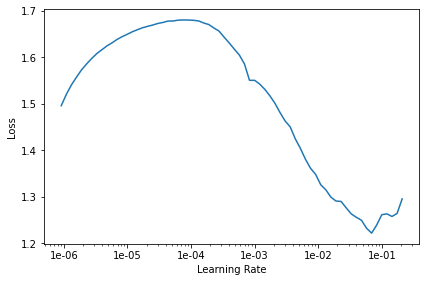

In [14]:
from torch.optim.adam import Adam
learning_rate_tsv = trainer.find_learning_rate(f'{save_dir}/riposte_class', Adam)

from flair.visual.training_curves import Plotter
plotter = Plotter()
plotter.plot_learning_rate(learning_rate_tsv)

Train the model:

In [15]:
%%time
# Start training
trainer.train(
    f'{save_dir}/riposte_class',
    learning_rate=LEARNING_RATE,
    mini_batch_size=BATCH_SIZE,
    max_epochs=EPOCHS,
    # monitor_test=True,
)

2022-05-28 07:49:00,557 ----------------------------------------------------------------------------------------------------
2022-05-28 07:49:00,559 Model: "TextPairClassifier(
  (decoder): Linear(in_features=512, out_features=6, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
  (locked_dropout): LockedDropout(p=0.0)
  (word_dropout): WordDropout(p=0.0)
  (loss_function): CrossEntropyLoss()
  (document_embeddings): DocumentRNNEmbeddings(
    (embeddings): StackedEmbeddings(
      (list_embedding_0): FlairEmbeddings(
        (lm): LanguageModel(
          (drop): Dropout(p=0.05, inplace=False)
          (encoder): Embedding(300, 100)
          (rnn): LSTM(100, 2048)
          (decoder): Linear(in_features=2048, out_features=300, bias=True)
        )
      )
      (list_embedding_1): FlairEmbeddings(
        (lm): LanguageModel(
          (drop): Dropout(p=0.05, inplace=False)
          (encoder): Embedding(300, 100)
          (rnn): LSTM(100, 2048)
          (decoder): Linear(in_f

100%|██████████| 17/17 [00:01<00:00, 11.90it/s]

2022-05-28 07:49:12,757 Evaluating as a multi-label problem: True
2022-05-28 07:49:12,782 DEV : loss 0.20571310818195343 - f1-score (micro avg)  0.4656
2022-05-28 07:49:12,790 BAD EPOCHS (no improvement): 0
2022-05-28 07:49:12,791 saving best model


2022-05-28 07:49:13,185 ----------------------------------------------------------------------------------------------------
2022-05-28 07:49:14,264 epoch 2 - iter 12/125 - loss 0.39476802 - samples/sec: 89.19 - lr: 0.001000
2022-05-28 07:49:15,297 epoch 2 - iter 24/125 - loss 0.37088353 - samples/sec: 93.12 - lr: 0.001000
2022-05-28 07:49:16,273 epoch 2 - iter 36/125 - loss 0.41324471 - samples/sec: 98.46 - lr: 0.001000
2022-05-28 07:49:17,260 epoch 2 - iter 48/125 - loss 0.39650744 - samples/sec: 97.65 - lr: 0.001000
2022-05-28 07:49:18,298 epoch 2 - iter 60/125 - loss 0.38751326 - samples/sec: 92.65 - lr: 0.001000
2022-05-28 07:49:19,280 epoch 2 - iter 72/125 - loss 0.38536692 - samples/sec: 97.88 - lr: 0.001000
2022-05-28 07:49:20,237 epoch 2 - iter 84/125 - loss 0.37253697 - samples/sec: 100.73 - lr: 0.001000
2022-05-28 07:49:21,324 epoch 2 - iter 96/125 - loss 0.38479612 - samples/sec: 88.64 - lr: 0.001000
2022-05-28 07:49:22,347 epoch 2 - iter 108/125 - loss 0.37838172 - samples

100%|██████████| 17/17 [00:01<00:00, 11.68it/s]

2022-05-28 07:49:25,260 Evaluating as a multi-label problem: True
2022-05-28 07:49:25,290 DEV : loss 0.1925327181816101 - f1-score (micro avg)  0.4656
2022-05-28 07:49:25,301 BAD EPOCHS (no improvement): 0
2022-05-28 07:49:25,304 ----------------------------------------------------------------------------------------------------


2022-05-28 07:49:26,320 epoch 3 - iter 12/125 - loss 0.34458310 - samples/sec: 94.83 - lr: 0.001000
2022-05-28 07:49:27,343 epoch 3 - iter 24/125 - loss 0.29767789 - samples/sec: 93.98 - lr: 0.001000
2022-05-28 07:49:28,355 epoch 3 - iter 36/125 - loss 0.27479632 - samples/sec: 95.07 - lr: 0.001000
2022-05-28 07:49:29,332 epoch 3 - iter 48/125 - loss 0.31022240 - samples/sec: 98.35 - lr: 0.001000
2022-05-28 07:49:30,396 epoch 3 - iter 60/125 - loss 0.30235463 - samples/sec: 90.39 - lr: 0.001000
2022-05-28 07:49:31,398 epoch 3 - iter 72/125 - loss 0.31466708 - samples/sec: 96.00 - lr: 0.001000
2022-05-28 07:49:32,498 epoch 3 - iter 84/125 - loss 0.31809447 - samples/sec: 87.34 - lr: 0.001000
2022-05-28 07:49:33,454 epoch 3 - iter 96/125 - loss 0.33091853 - samples/sec: 100.65 - lr: 0.001000
2022-05-28 07:49:34,446 epoch 3 - iter 108/125 - loss 0.33179192 - samples/sec: 96.88 - lr: 0.001000
2022-05-28 07:49:35,557 epoch 3 - iter 120/125 - loss 0.33011033 - samples/sec: 86.55 - lr: 0.0010

100%|██████████| 17/17 [00:01<00:00, 11.92it/s]

2022-05-28 07:49:37,660 Evaluating as a multi-label problem: True
2022-05-28 07:49:37,682 DEV : loss 0.17083603143692017 - f1-score (micro avg)  0.4656
2022-05-28 07:49:37,689 BAD EPOCHS (no improvement): 0
2022-05-28 07:49:37,690 ----------------------------------------------------------------------------------------------------


2022-05-28 07:49:38,703 epoch 4 - iter 12/125 - loss 0.39396431 - samples/sec: 95.00 - lr: 0.001000
2022-05-28 07:49:39,659 epoch 4 - iter 24/125 - loss 0.32217662 - samples/sec: 100.56 - lr: 0.001000
2022-05-28 07:49:40,711 epoch 4 - iter 36/125 - loss 0.30682221 - samples/sec: 91.41 - lr: 0.001000
2022-05-28 07:49:41,727 epoch 4 - iter 48/125 - loss 0.32139620 - samples/sec: 94.62 - lr: 0.001000
2022-05-28 07:49:42,760 epoch 4 - iter 60/125 - loss 0.32980017 - samples/sec: 93.08 - lr: 0.001000
2022-05-28 07:49:43,785 epoch 4 - iter 72/125 - loss 0.32223157 - samples/sec: 93.81 - lr: 0.001000
2022-05-28 07:49:44,779 epoch 4 - iter 84/125 - loss 0.31641744 - samples/sec: 96.75 - lr: 0.001000
2022-05-28 07:49:45,802 epoch 4 - iter 96/125 - loss 0.31475413 - samples/sec: 93.94 - lr: 0.001000
2022-05-28 07:49:46,913 epoch 4 - iter 108/125 - loss 0.31252877 - samples/sec: 86.58 - lr: 0.001000
2022-05-28 07:49:47,987 epoch 4 - iter 120/125 - loss 0.31143708 - samples/sec: 89.46 - lr: 0.0010

100%|██████████| 17/17 [00:01<00:00, 11.93it/s]

2022-05-28 07:49:49,837 Evaluating as a multi-label problem: True
2022-05-28 07:49:49,858 DEV : loss 0.13965269923210144 - f1-score (micro avg)  0.4656
2022-05-28 07:49:49,864 BAD EPOCHS (no improvement): 0
2022-05-28 07:49:49,865 ----------------------------------------------------------------------------------------------------


2022-05-28 07:49:50,947 epoch 5 - iter 12/125 - loss 0.27419080 - samples/sec: 89.02 - lr: 0.001000
2022-05-28 07:49:52,048 epoch 5 - iter 24/125 - loss 0.31448764 - samples/sec: 87.29 - lr: 0.001000
2022-05-28 07:49:53,170 epoch 5 - iter 36/125 - loss 0.32670727 - samples/sec: 85.81 - lr: 0.001000
2022-05-28 07:49:54,198 epoch 5 - iter 48/125 - loss 0.32488187 - samples/sec: 93.52 - lr: 0.001000
2022-05-28 07:49:55,100 epoch 5 - iter 60/125 - loss 0.31373440 - samples/sec: 106.57 - lr: 0.001000
2022-05-28 07:49:56,124 epoch 5 - iter 72/125 - loss 0.31976960 - samples/sec: 93.91 - lr: 0.001000
2022-05-28 07:49:57,083 epoch 5 - iter 84/125 - loss 0.31612270 - samples/sec: 100.28 - lr: 0.001000
2022-05-28 07:49:58,104 epoch 5 - iter 96/125 - loss 0.32033304 - samples/sec: 94.15 - lr: 0.001000
2022-05-28 07:49:59,135 epoch 5 - iter 108/125 - loss 0.31834133 - samples/sec: 93.38 - lr: 0.001000
2022-05-28 07:50:00,141 epoch 5 - iter 120/125 - loss 0.31717688 - samples/sec: 95.48 - lr: 0.001

100%|██████████| 17/17 [00:01<00:00, 11.88it/s]

2022-05-28 07:50:01,998 Evaluating as a multi-label problem: True
2022-05-28 07:50:02,020 DEV : loss 0.17154286801815033 - f1-score (micro avg)  0.4656
2022-05-28 07:50:02,028 BAD EPOCHS (no improvement): 1
2022-05-28 07:50:02,029 ----------------------------------------------------------------------------------------------------


2022-05-28 07:50:03,005 epoch 6 - iter 12/125 - loss 0.30382820 - samples/sec: 98.53 - lr: 0.001000
2022-05-28 07:50:04,029 epoch 6 - iter 24/125 - loss 0.31070770 - samples/sec: 93.96 - lr: 0.001000
2022-05-28 07:50:05,207 epoch 6 - iter 36/125 - loss 0.29797282 - samples/sec: 81.68 - lr: 0.001000
2022-05-28 07:50:06,191 epoch 6 - iter 48/125 - loss 0.31147080 - samples/sec: 97.74 - lr: 0.001000
2022-05-28 07:50:07,258 epoch 6 - iter 60/125 - loss 0.30902839 - samples/sec: 90.03 - lr: 0.001000
2022-05-28 07:50:08,230 epoch 6 - iter 72/125 - loss 0.32121753 - samples/sec: 98.98 - lr: 0.001000
2022-05-28 07:50:09,201 epoch 6 - iter 84/125 - loss 0.30667161 - samples/sec: 98.97 - lr: 0.001000
2022-05-28 07:50:10,230 epoch 6 - iter 96/125 - loss 0.30180072 - samples/sec: 93.46 - lr: 0.001000
2022-05-28 07:50:11,204 epoch 6 - iter 108/125 - loss 0.29579717 - samples/sec: 98.66 - lr: 0.001000
2022-05-28 07:50:12,291 epoch 6 - iter 120/125 - loss 0.28953249 - samples/sec: 88.45 - lr: 0.00100

100%|██████████| 17/17 [00:01<00:00, 11.88it/s]

2022-05-28 07:50:14,129 Evaluating as a multi-label problem: True
2022-05-28 07:50:14,167 DEV : loss 0.13565702736377716 - f1-score (micro avg)  0.4656
2022-05-28 07:50:14,179 BAD EPOCHS (no improvement): 0
2022-05-28 07:50:14,182 ----------------------------------------------------------------------------------------------------


2022-05-28 07:50:15,320 epoch 7 - iter 12/125 - loss 0.28428508 - samples/sec: 84.59 - lr: 0.001000
2022-05-28 07:50:16,308 epoch 7 - iter 24/125 - loss 0.25561324 - samples/sec: 97.32 - lr: 0.001000
2022-05-28 07:50:17,392 epoch 7 - iter 36/125 - loss 0.25012025 - samples/sec: 88.80 - lr: 0.001000
2022-05-28 07:50:18,405 epoch 7 - iter 48/125 - loss 0.26160943 - samples/sec: 94.87 - lr: 0.001000
2022-05-28 07:50:19,392 epoch 7 - iter 60/125 - loss 0.27476484 - samples/sec: 97.44 - lr: 0.001000
2022-05-28 07:50:20,402 epoch 7 - iter 72/125 - loss 0.27603127 - samples/sec: 95.17 - lr: 0.001000
2022-05-28 07:50:21,386 epoch 7 - iter 84/125 - loss 0.27958366 - samples/sec: 97.78 - lr: 0.001000
2022-05-28 07:50:22,417 epoch 7 - iter 96/125 - loss 0.27516935 - samples/sec: 93.21 - lr: 0.001000
2022-05-28 07:50:23,375 epoch 7 - iter 108/125 - loss 0.27023978 - samples/sec: 100.43 - lr: 0.001000
2022-05-28 07:50:24,347 epoch 7 - iter 120/125 - loss 0.27543636 - samples/sec: 98.93 - lr: 0.0010

100%|██████████| 17/17 [00:01<00:00, 11.74it/s]

2022-05-28 07:50:26,223 Evaluating as a multi-label problem: True
2022-05-28 07:50:26,244 DEV : loss 0.11697835475206375 - f1-score (micro avg)  0.4656
2022-05-28 07:50:26,253 BAD EPOCHS (no improvement): 0
2022-05-28 07:50:26,254 ----------------------------------------------------------------------------------------------------


2022-05-28 07:50:27,233 epoch 8 - iter 12/125 - loss 0.24474518 - samples/sec: 98.23 - lr: 0.001000
2022-05-28 07:50:28,209 epoch 8 - iter 24/125 - loss 0.26990345 - samples/sec: 98.47 - lr: 0.001000
2022-05-28 07:50:29,299 epoch 8 - iter 36/125 - loss 0.28661304 - samples/sec: 88.17 - lr: 0.001000
2022-05-28 07:50:30,289 epoch 8 - iter 48/125 - loss 0.26782006 - samples/sec: 97.12 - lr: 0.001000
2022-05-28 07:50:31,372 epoch 8 - iter 60/125 - loss 0.26124561 - samples/sec: 88.75 - lr: 0.001000
2022-05-28 07:50:32,474 epoch 8 - iter 72/125 - loss 0.26571914 - samples/sec: 87.42 - lr: 0.001000
2022-05-28 07:50:33,470 epoch 8 - iter 84/125 - loss 0.27034975 - samples/sec: 96.59 - lr: 0.001000
2022-05-28 07:50:34,469 epoch 8 - iter 96/125 - loss 0.27445324 - samples/sec: 96.20 - lr: 0.001000
2022-05-28 07:50:35,575 epoch 8 - iter 108/125 - loss 0.27344693 - samples/sec: 86.93 - lr: 0.001000
2022-05-28 07:50:36,574 epoch 8 - iter 120/125 - loss 0.26501733 - samples/sec: 96.23 - lr: 0.00100

100%|██████████| 17/17 [00:01<00:00, 11.90it/s]

2022-05-28 07:50:38,452 Evaluating as a multi-label problem: True
2022-05-28 07:50:38,473 DEV : loss 0.1335631012916565 - f1-score (micro avg)  0.4656
2022-05-28 07:50:38,479 BAD EPOCHS (no improvement): 1
2022-05-28 07:50:38,480 ----------------------------------------------------------------------------------------------------


2022-05-28 07:50:39,421 epoch 9 - iter 12/125 - loss 0.28550708 - samples/sec: 102.30 - lr: 0.001000
2022-05-28 07:50:40,540 epoch 9 - iter 24/125 - loss 0.27849954 - samples/sec: 85.88 - lr: 0.001000
2022-05-28 07:50:41,598 epoch 9 - iter 36/125 - loss 0.26121785 - samples/sec: 90.93 - lr: 0.001000
2022-05-28 07:50:42,539 epoch 9 - iter 48/125 - loss 0.26217714 - samples/sec: 102.19 - lr: 0.001000
2022-05-28 07:50:43,502 epoch 9 - iter 60/125 - loss 0.25800285 - samples/sec: 99.82 - lr: 0.001000
2022-05-28 07:50:44,569 epoch 9 - iter 72/125 - loss 0.25477623 - samples/sec: 90.09 - lr: 0.001000
2022-05-28 07:50:45,574 epoch 9 - iter 84/125 - loss 0.25416467 - samples/sec: 95.62 - lr: 0.001000
2022-05-28 07:50:46,554 epoch 9 - iter 96/125 - loss 0.25692703 - samples/sec: 98.12 - lr: 0.001000
2022-05-28 07:50:47,617 epoch 9 - iter 108/125 - loss 0.25517725 - samples/sec: 90.46 - lr: 0.001000
2022-05-28 07:50:48,714 epoch 9 - iter 120/125 - loss 0.25246839 - samples/sec: 87.90 - lr: 0.001

100%|██████████| 17/17 [00:01<00:00, 11.95it/s]

2022-05-28 07:50:50,573 Evaluating as a multi-label problem: True
2022-05-28 07:50:50,596 DEV : loss 0.14184610545635223 - f1-score (micro avg)  0.4656
2022-05-28 07:50:50,603 BAD EPOCHS (no improvement): 2
2022-05-28 07:50:50,604 ----------------------------------------------------------------------------------------------------


2022-05-28 07:50:51,774 epoch 10 - iter 12/125 - loss 0.26174350 - samples/sec: 82.27 - lr: 0.001000
2022-05-28 07:50:52,756 epoch 10 - iter 24/125 - loss 0.28388573 - samples/sec: 97.85 - lr: 0.001000
2022-05-28 07:50:53,720 epoch 10 - iter 36/125 - loss 0.28068834 - samples/sec: 99.75 - lr: 0.001000
2022-05-28 07:50:54,695 epoch 10 - iter 48/125 - loss 0.26527990 - samples/sec: 98.55 - lr: 0.001000
2022-05-28 07:50:55,706 epoch 10 - iter 60/125 - loss 0.25695972 - samples/sec: 95.13 - lr: 0.001000
2022-05-28 07:50:56,701 epoch 10 - iter 72/125 - loss 0.25978994 - samples/sec: 96.65 - lr: 0.001000
2022-05-28 07:50:57,730 epoch 10 - iter 84/125 - loss 0.25588978 - samples/sec: 93.39 - lr: 0.001000
2022-05-28 07:50:58,755 epoch 10 - iter 96/125 - loss 0.25889887 - samples/sec: 93.80 - lr: 0.001000
2022-05-28 07:50:59,776 epoch 10 - iter 108/125 - loss 0.26219055 - samples/sec: 94.17 - lr: 0.001000
2022-05-28 07:51:00,823 epoch 10 - iter 120/125 - loss 0.25931779 - samples/sec: 91.81 - l

100%|██████████| 17/17 [00:01<00:00, 11.90it/s]

2022-05-28 07:51:02,667 Evaluating as a multi-label problem: True
2022-05-28 07:51:02,690 DEV : loss 0.15511421859264374 - f1-score (micro avg)  0.4656
2022-05-28 07:51:02,698 BAD EPOCHS (no improvement): 3
2022-05-28 07:51:02,700 ----------------------------------------------------------------------------------------------------


2022-05-28 07:51:03,723 epoch 11 - iter 12/125 - loss 0.25782699 - samples/sec: 94.10 - lr: 0.001000
2022-05-28 07:51:04,802 epoch 11 - iter 24/125 - loss 0.25049549 - samples/sec: 89.32 - lr: 0.001000
2022-05-28 07:51:05,863 epoch 11 - iter 36/125 - loss 0.23532712 - samples/sec: 90.62 - lr: 0.001000
2022-05-28 07:51:06,854 epoch 11 - iter 48/125 - loss 0.24255647 - samples/sec: 97.02 - lr: 0.001000
2022-05-28 07:51:07,903 epoch 11 - iter 60/125 - loss 0.23716720 - samples/sec: 91.63 - lr: 0.001000
2022-05-28 07:51:08,923 epoch 11 - iter 72/125 - loss 0.24425720 - samples/sec: 94.21 - lr: 0.001000
2022-05-28 07:51:09,880 epoch 11 - iter 84/125 - loss 0.24821954 - samples/sec: 100.52 - lr: 0.001000
2022-05-28 07:51:10,855 epoch 11 - iter 96/125 - loss 0.23731035 - samples/sec: 98.62 - lr: 0.001000
2022-05-28 07:51:11,971 epoch 11 - iter 108/125 - loss 0.24011376 - samples/sec: 86.13 - lr: 0.001000
2022-05-28 07:51:13,004 epoch 11 - iter 120/125 - loss 0.24371670 - samples/sec: 93.01 - 

100%|██████████| 17/17 [00:01<00:00, 11.88it/s]

2022-05-28 07:51:14,861 Evaluating as a multi-label problem: True
2022-05-28 07:51:14,882 DEV : loss 0.11914335191249847 - f1-score (micro avg)  0.4656
2022-05-28 07:51:14,890 Epoch    11: reducing learning rate of group 0 to 5.0000e-04.
2022-05-28 07:51:14,891 BAD EPOCHS (no improvement): 4
2022-05-28 07:51:14,892 ----------------------------------------------------------------------------------------------------


2022-05-28 07:51:15,952 epoch 12 - iter 12/125 - loss 0.23648122 - samples/sec: 90.80 - lr: 0.000500
2022-05-28 07:51:16,905 epoch 12 - iter 24/125 - loss 0.25685921 - samples/sec: 100.88 - lr: 0.000500
2022-05-28 07:51:17,905 epoch 12 - iter 36/125 - loss 0.25342470 - samples/sec: 96.13 - lr: 0.000500
2022-05-28 07:51:18,893 epoch 12 - iter 48/125 - loss 0.25331114 - samples/sec: 97.30 - lr: 0.000500
2022-05-28 07:51:19,966 epoch 12 - iter 60/125 - loss 0.25344676 - samples/sec: 89.61 - lr: 0.000500
2022-05-28 07:51:21,013 epoch 12 - iter 72/125 - loss 0.24768257 - samples/sec: 91.86 - lr: 0.000500
2022-05-28 07:51:22,056 epoch 12 - iter 84/125 - loss 0.23815000 - samples/sec: 92.16 - lr: 0.000500
2022-05-28 07:51:23,023 epoch 12 - iter 96/125 - loss 0.23968276 - samples/sec: 99.43 - lr: 0.000500
2022-05-28 07:51:24,098 epoch 12 - iter 108/125 - loss 0.23725059 - samples/sec: 89.41 - lr: 0.000500
2022-05-28 07:51:25,124 epoch 12 - iter 120/125 - loss 0.23539924 - samples/sec: 93.74 - 

100%|██████████| 17/17 [00:01<00:00, 11.85it/s]

2022-05-28 07:51:26,968 Evaluating as a multi-label problem: True
2022-05-28 07:51:26,988 DEV : loss 0.12418109178543091 - f1-score (micro avg)  0.4656
2022-05-28 07:51:26,996 BAD EPOCHS (no improvement): 1
2022-05-28 07:51:26,997 ----------------------------------------------------------------------------------------------------


2022-05-28 07:51:27,981 epoch 13 - iter 12/125 - loss 0.28535433 - samples/sec: 97.90 - lr: 0.000500
2022-05-28 07:51:28,967 epoch 13 - iter 24/125 - loss 0.25524592 - samples/sec: 97.55 - lr: 0.000500
2022-05-28 07:51:29,960 epoch 13 - iter 36/125 - loss 0.25948097 - samples/sec: 96.79 - lr: 0.000500
2022-05-28 07:51:31,286 epoch 13 - iter 48/125 - loss 0.24476896 - samples/sec: 72.47 - lr: 0.000500
2022-05-28 07:51:32,410 epoch 13 - iter 60/125 - loss 0.24484832 - samples/sec: 85.68 - lr: 0.000500
2022-05-28 07:51:33,476 epoch 13 - iter 72/125 - loss 0.23001258 - samples/sec: 90.18 - lr: 0.000500
2022-05-28 07:51:34,454 epoch 13 - iter 84/125 - loss 0.23271192 - samples/sec: 98.36 - lr: 0.000500
2022-05-28 07:51:35,444 epoch 13 - iter 96/125 - loss 0.23948931 - samples/sec: 97.12 - lr: 0.000500
2022-05-28 07:51:36,516 epoch 13 - iter 108/125 - loss 0.23526750 - samples/sec: 89.64 - lr: 0.000500
2022-05-28 07:51:37,553 epoch 13 - iter 120/125 - loss 0.23955986 - samples/sec: 92.78 - l

100%|██████████| 17/17 [00:01<00:00, 11.91it/s]

2022-05-28 07:51:39,354 Evaluating as a multi-label problem: True
2022-05-28 07:51:39,374 DEV : loss 0.11777763068675995 - f1-score (micro avg)  0.4656
2022-05-28 07:51:39,381 BAD EPOCHS (no improvement): 2
2022-05-28 07:51:39,382 ----------------------------------------------------------------------------------------------------


2022-05-28 07:51:40,396 epoch 14 - iter 12/125 - loss 0.17897158 - samples/sec: 94.88 - lr: 0.000500
2022-05-28 07:51:41,403 epoch 14 - iter 24/125 - loss 0.18958097 - samples/sec: 95.48 - lr: 0.000500
2022-05-28 07:51:42,556 epoch 14 - iter 36/125 - loss 0.17940925 - samples/sec: 83.37 - lr: 0.000500
2022-05-28 07:51:43,508 epoch 14 - iter 48/125 - loss 0.18816879 - samples/sec: 101.06 - lr: 0.000500
2022-05-28 07:51:44,502 epoch 14 - iter 60/125 - loss 0.19645010 - samples/sec: 96.67 - lr: 0.000500
2022-05-28 07:51:45,551 epoch 14 - iter 72/125 - loss 0.20299751 - samples/sec: 91.62 - lr: 0.000500
2022-05-28 07:51:46,531 epoch 14 - iter 84/125 - loss 0.21935171 - samples/sec: 98.09 - lr: 0.000500
2022-05-28 07:51:47,549 epoch 14 - iter 96/125 - loss 0.22909943 - samples/sec: 94.45 - lr: 0.000500
2022-05-28 07:51:48,541 epoch 14 - iter 108/125 - loss 0.22751912 - samples/sec: 97.00 - lr: 0.000500
2022-05-28 07:51:49,603 epoch 14 - iter 120/125 - loss 0.22977735 - samples/sec: 90.49 - 

100%|██████████| 17/17 [00:01<00:00, 11.90it/s]

2022-05-28 07:51:51,397 Evaluating as a multi-label problem: True
2022-05-28 07:51:51,419 DEV : loss 0.1207590326666832 - f1-score (micro avg)  0.4656
2022-05-28 07:51:51,428 BAD EPOCHS (no improvement): 3
2022-05-28 07:51:51,430 ----------------------------------------------------------------------------------------------------


2022-05-28 07:51:52,383 epoch 15 - iter 12/125 - loss 0.21515468 - samples/sec: 101.02 - lr: 0.000500
2022-05-28 07:51:53,451 epoch 15 - iter 24/125 - loss 0.24712484 - samples/sec: 90.00 - lr: 0.000500
2022-05-28 07:51:54,517 epoch 15 - iter 36/125 - loss 0.25714261 - samples/sec: 90.35 - lr: 0.000500
2022-05-28 07:51:55,444 epoch 15 - iter 48/125 - loss 0.24889840 - samples/sec: 103.75 - lr: 0.000500
2022-05-28 07:51:56,593 epoch 15 - iter 60/125 - loss 0.24852061 - samples/sec: 83.73 - lr: 0.000500
2022-05-28 07:51:57,591 epoch 15 - iter 72/125 - loss 0.24980636 - samples/sec: 96.34 - lr: 0.000500
2022-05-28 07:51:58,694 epoch 15 - iter 84/125 - loss 0.25088007 - samples/sec: 87.12 - lr: 0.000500
2022-05-28 07:51:59,704 epoch 15 - iter 96/125 - loss 0.25312626 - samples/sec: 95.15 - lr: 0.000500
2022-05-28 07:52:00,744 epoch 15 - iter 108/125 - loss 0.24596267 - samples/sec: 92.51 - lr: 0.000500
2022-05-28 07:52:01,759 epoch 15 - iter 120/125 - loss 0.24766482 - samples/sec: 94.73 -

100%|██████████| 17/17 [00:01<00:00, 11.95it/s]

2022-05-28 07:52:03,582 Evaluating as a multi-label problem: True
2022-05-28 07:52:03,603 DEV : loss 0.14881159365177155 - f1-score (micro avg)  0.4656
2022-05-28 07:52:03,610 Epoch    15: reducing learning rate of group 0 to 2.5000e-04.
2022-05-28 07:52:03,611 BAD EPOCHS (no improvement): 4
2022-05-28 07:52:03,611 ----------------------------------------------------------------------------------------------------


2022-05-28 07:52:04,608 epoch 16 - iter 12/125 - loss 0.25012056 - samples/sec: 96.57 - lr: 0.000250
2022-05-28 07:52:05,621 epoch 16 - iter 24/125 - loss 0.21555764 - samples/sec: 94.92 - lr: 0.000250
2022-05-28 07:52:06,646 epoch 16 - iter 36/125 - loss 0.21697380 - samples/sec: 93.84 - lr: 0.000250
2022-05-28 07:52:07,612 epoch 16 - iter 48/125 - loss 0.21338443 - samples/sec: 99.55 - lr: 0.000250
2022-05-28 07:52:08,695 epoch 16 - iter 60/125 - loss 0.22218723 - samples/sec: 88.70 - lr: 0.000250
2022-05-28 07:52:09,704 epoch 16 - iter 72/125 - loss 0.22286764 - samples/sec: 95.28 - lr: 0.000250
2022-05-28 07:52:10,792 epoch 16 - iter 84/125 - loss 0.23241582 - samples/sec: 88.64 - lr: 0.000250
2022-05-28 07:52:11,788 epoch 16 - iter 96/125 - loss 0.23266191 - samples/sec: 96.51 - lr: 0.000250
2022-05-28 07:52:12,790 epoch 16 - iter 108/125 - loss 0.24336714 - samples/sec: 95.89 - lr: 0.000250
2022-05-28 07:52:13,840 epoch 16 - iter 120/125 - loss 0.24168951 - samples/sec: 91.61 - l

100%|██████████| 17/17 [00:01<00:00, 11.77it/s]

2022-05-28 07:52:15,690 Evaluating as a multi-label problem: True
2022-05-28 07:52:15,711 DEV : loss 0.12485641241073608 - f1-score (micro avg)  0.4656
2022-05-28 07:52:15,718 BAD EPOCHS (no improvement): 1
2022-05-28 07:52:15,719 ----------------------------------------------------------------------------------------------------


2022-05-28 07:52:16,713 epoch 17 - iter 12/125 - loss 0.19806232 - samples/sec: 96.77 - lr: 0.000250
2022-05-28 07:52:17,801 epoch 17 - iter 24/125 - loss 0.22225462 - samples/sec: 88.32 - lr: 0.000250
2022-05-28 07:52:18,786 epoch 17 - iter 36/125 - loss 0.22564652 - samples/sec: 97.69 - lr: 0.000250
2022-05-28 07:52:19,820 epoch 17 - iter 48/125 - loss 0.22798310 - samples/sec: 92.93 - lr: 0.000250
2022-05-28 07:52:20,863 epoch 17 - iter 60/125 - loss 0.23027782 - samples/sec: 92.27 - lr: 0.000250
2022-05-28 07:52:21,894 epoch 17 - iter 72/125 - loss 0.23197573 - samples/sec: 93.24 - lr: 0.000250
2022-05-28 07:52:22,831 epoch 17 - iter 84/125 - loss 0.23549537 - samples/sec: 102.56 - lr: 0.000250
2022-05-28 07:52:23,888 epoch 17 - iter 96/125 - loss 0.22800055 - samples/sec: 90.95 - lr: 0.000250
2022-05-28 07:52:24,860 epoch 17 - iter 108/125 - loss 0.23132553 - samples/sec: 98.98 - lr: 0.000250
2022-05-28 07:52:25,881 epoch 17 - iter 120/125 - loss 0.23223346 - samples/sec: 94.13 - 

100%|██████████| 17/17 [00:01<00:00, 11.79it/s]

2022-05-28 07:52:27,828 Evaluating as a multi-label problem: True
2022-05-28 07:52:27,852 DEV : loss 0.1201748326420784 - f1-score (micro avg)  0.4656
2022-05-28 07:52:27,858 BAD EPOCHS (no improvement): 2
2022-05-28 07:52:27,859 ----------------------------------------------------------------------------------------------------


2022-05-28 07:52:28,885 epoch 18 - iter 12/125 - loss 0.31103390 - samples/sec: 93.75 - lr: 0.000250
2022-05-28 07:52:29,900 epoch 18 - iter 24/125 - loss 0.25797064 - samples/sec: 94.67 - lr: 0.000250
2022-05-28 07:52:30,874 epoch 18 - iter 36/125 - loss 0.22480153 - samples/sec: 98.80 - lr: 0.000250
2022-05-28 07:52:31,945 epoch 18 - iter 48/125 - loss 0.21700087 - samples/sec: 89.71 - lr: 0.000250
2022-05-28 07:52:32,893 epoch 18 - iter 60/125 - loss 0.23270463 - samples/sec: 101.40 - lr: 0.000250
2022-05-28 07:52:34,017 epoch 18 - iter 72/125 - loss 0.23467039 - samples/sec: 85.55 - lr: 0.000250
2022-05-28 07:52:34,998 epoch 18 - iter 84/125 - loss 0.23271551 - samples/sec: 97.98 - lr: 0.000250
2022-05-28 07:52:36,020 epoch 18 - iter 96/125 - loss 0.23224672 - samples/sec: 94.09 - lr: 0.000250
2022-05-28 07:52:37,032 epoch 18 - iter 108/125 - loss 0.23089642 - samples/sec: 95.01 - lr: 0.000250
2022-05-28 07:52:38,075 epoch 18 - iter 120/125 - loss 0.23212126 - samples/sec: 92.16 - 

100%|██████████| 17/17 [00:01<00:00, 11.86it/s]

2022-05-28 07:52:39,922 Evaluating as a multi-label problem: True
2022-05-28 07:52:39,944 DEV : loss 0.12580524384975433 - f1-score (micro avg)  0.4656
2022-05-28 07:52:39,952 BAD EPOCHS (no improvement): 3
2022-05-28 07:52:39,953 ----------------------------------------------------------------------------------------------------


2022-05-28 07:52:40,925 epoch 19 - iter 12/125 - loss 0.21644647 - samples/sec: 99.00 - lr: 0.000250
2022-05-28 07:52:41,927 epoch 19 - iter 24/125 - loss 0.21377573 - samples/sec: 96.02 - lr: 0.000250
2022-05-28 07:52:42,946 epoch 19 - iter 36/125 - loss 0.22009376 - samples/sec: 94.38 - lr: 0.000250
2022-05-28 07:52:44,087 epoch 19 - iter 48/125 - loss 0.21458156 - samples/sec: 84.26 - lr: 0.000250
2022-05-28 07:52:45,072 epoch 19 - iter 60/125 - loss 0.21707955 - samples/sec: 97.59 - lr: 0.000250
2022-05-28 07:52:46,128 epoch 19 - iter 72/125 - loss 0.22502988 - samples/sec: 91.08 - lr: 0.000250
2022-05-28 07:52:47,175 epoch 19 - iter 84/125 - loss 0.22626201 - samples/sec: 91.78 - lr: 0.000250
2022-05-28 07:52:48,168 epoch 19 - iter 96/125 - loss 0.22322349 - samples/sec: 96.85 - lr: 0.000250
2022-05-28 07:52:49,214 epoch 19 - iter 108/125 - loss 0.22732111 - samples/sec: 92.22 - lr: 0.000250
2022-05-28 07:52:50,120 epoch 19 - iter 120/125 - loss 0.22625202 - samples/sec: 106.05 - 

100%|██████████| 17/17 [00:01<00:00, 11.90it/s]

2022-05-28 07:52:51,993 Evaluating as a multi-label problem: True
2022-05-28 07:52:52,015 DEV : loss 0.11542245000600815 - f1-score (micro avg)  0.4656
2022-05-28 07:52:52,022 BAD EPOCHS (no improvement): 0
2022-05-28 07:52:52,023 ----------------------------------------------------------------------------------------------------


2022-05-28 07:52:53,089 epoch 20 - iter 12/125 - loss 0.26253619 - samples/sec: 90.18 - lr: 0.000250
2022-05-28 07:52:54,071 epoch 20 - iter 24/125 - loss 0.25264785 - samples/sec: 97.88 - lr: 0.000250
2022-05-28 07:52:55,175 epoch 20 - iter 36/125 - loss 0.23910506 - samples/sec: 87.10 - lr: 0.000250
2022-05-28 07:52:56,154 epoch 20 - iter 48/125 - loss 0.22652141 - samples/sec: 98.18 - lr: 0.000250
2022-05-28 07:52:57,097 epoch 20 - iter 60/125 - loss 0.21584942 - samples/sec: 102.00 - lr: 0.000250
2022-05-28 07:52:58,140 epoch 20 - iter 72/125 - loss 0.22342820 - samples/sec: 92.20 - lr: 0.000250
2022-05-28 07:52:59,128 epoch 20 - iter 84/125 - loss 0.22550246 - samples/sec: 97.30 - lr: 0.000250
2022-05-28 07:53:00,197 epoch 20 - iter 96/125 - loss 0.22054998 - samples/sec: 89.93 - lr: 0.000250
2022-05-28 07:53:01,258 epoch 20 - iter 108/125 - loss 0.22338864 - samples/sec: 90.58 - lr: 0.000250
2022-05-28 07:53:02,242 epoch 20 - iter 120/125 - loss 0.21669362 - samples/sec: 97.78 - 

100%|██████████| 17/17 [00:01<00:00, 11.93it/s]

2022-05-28 07:53:04,079 Evaluating as a multi-label problem: True
2022-05-28 07:53:04,102 DEV : loss 0.14691464602947235 - f1-score (micro avg)  0.4656
2022-05-28 07:53:04,110 BAD EPOCHS (no improvement): 1


2022-05-28 07:53:04,507 ----------------------------------------------------------------------------------------------------
2022-05-28 07:53:04,508 loading file /kaggle/working/riposte_class/best-model.pt


100%|██████████| 17/17 [00:01<00:00, 13.01it/s]

2022-05-28 07:53:06,658 Evaluating as a multi-label problem: True
2022-05-28 07:53:06,681 0.6741	0.2935	0.409	0.1111
2022-05-28 07:53:06,681 
Results:
- F-score (micro) 0.409
- F-score (macro) 0.1611
- Accuracy 0.1111

By class:
                      precision    recall  f1-score   support

           <begging>     0.6741    1.0000    0.8053        91
             <hasty>     0.0000    0.0000    0.0000        86
<questionable_cause>     0.0000    0.0000    0.0000        66
       <red_herring>     0.0000    0.0000    0.0000        54
              <none>     0.0000    0.0000    0.0000        13

           micro avg     0.6741    0.2935    0.4090       310
           macro avg     0.1348    0.2000    0.1611       310
        weighted avg     0.1979    0.2935    0.2364       310
         samples avg     0.6741    0.3222    0.4141       310

2022-05-28 07:53:06,684 ----------------------------------------------------------------------------------------------------
CPU times: user 4min 4s

{'test_score': 0.4089887640449438,
 'dev_score_history': [0.46563192904656325,
  0.46563192904656325,
  0.46563192904656325,
  0.46563192904656325,
  0.46563192904656325,
  0.46563192904656325,
  0.46563192904656325,
  0.46563192904656325,
  0.46563192904656325,
  0.46563192904656325,
  0.46563192904656325,
  0.46563192904656325,
  0.46563192904656325,
  0.46563192904656325,
  0.46563192904656325,
  0.46563192904656325,
  0.46563192904656325,
  0.46563192904656325,
  0.46563192904656325,
  0.46563192904656325],
 'train_loss_history': [0.4875393140393573,
  0.38061148117672094,
  0.3322275674774184,
  0.30981784677869445,
  0.3215925958757107,
  0.289875996825812,
  0.2757028749397209,
  0.2645746679516049,
  0.25753599604418326,
  0.25758558440136836,
  0.24327660160692963,
  0.2317896805353112,
  0.24076905035906965,
  0.23403283921970022,
  0.24990769943317492,
  0.24043904937005736,
  0.23074584442365156,
  0.2329445461611132,
  0.22797785653127683,
  0.22194503288011294],
 'dev_los

## Plot Training Results

2022-05-28 07:53:07,791 ----------------------------------------------------------------------------------------------------
2022-05-28 07:53:07,792 WARNING: No LOSS found for test split in this data.
2022-05-28 07:53:07,793 Are you sure you want to plot LOSS and not another value?
2022-05-28 07:53:07,794 ----------------------------------------------------------------------------------------------------
2022-05-28 07:53:07,815 ----------------------------------------------------------------------------------------------------
2022-05-28 07:53:07,816 WARNING: No F1 found for test split in this data.
2022-05-28 07:53:07,816 Are you sure you want to plot F1 and not another value?
2022-05-28 07:53:07,818 ----------------------------------------------------------------------------------------------------
2022-05-28 07:53:08,929 Loss and F1 plots are saved in /kaggle/working/riposte_class/training.png


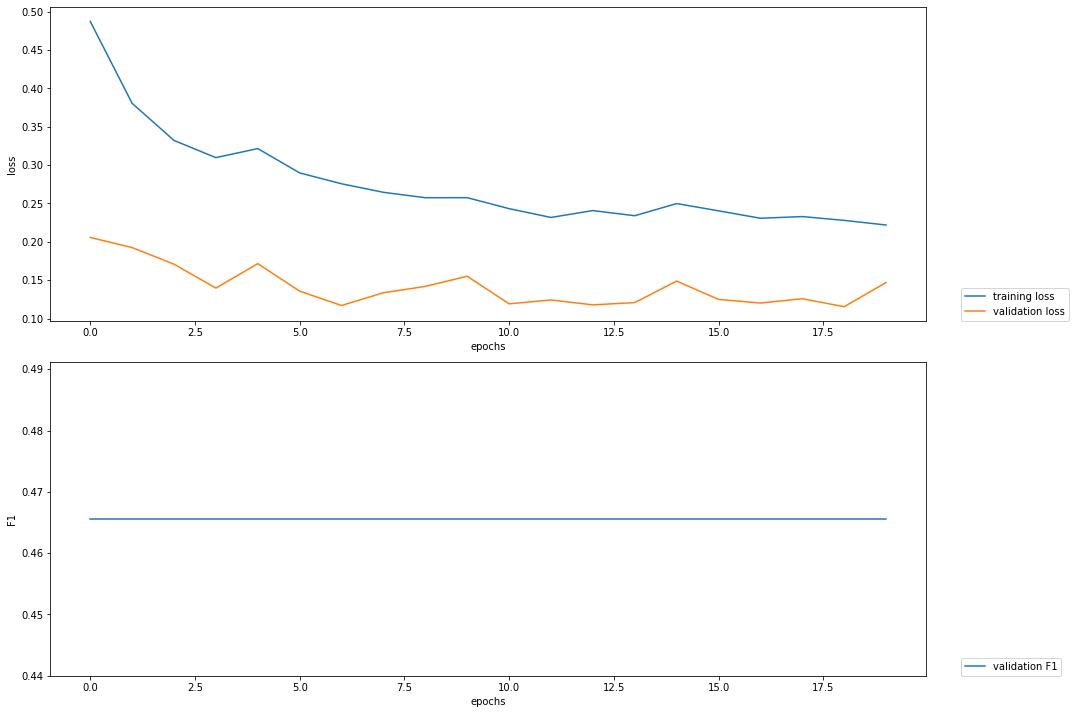

In [16]:
import matplotlib.pyplot as plt
from flair.visual.training_curves import Plotter

plotter = Plotter()
plotter.plot_training_curves(f'{save_dir}/riposte_class/loss.tsv')